In [1]:
!make build

---------CLEANING---------
rm -f lib/*.a
rm -f vectorsum_methods*
rm -f sourcecode_vectorsum_methods.cpp
rm -rf build
--------------------------
----COMPILE CUDA FILES----
nvcc --compiler-options -fPIC -lib -odir lib -o lib/libvectorsum.a cuda/vectorsum.cu 
--------------------------
---COMPILE CYTHON FILES---
python3 compile_cython.py build_ext --inplace
{'home': '/usr/local/cuda', 'nvcc': '/usr/local/cuda/bin/nvcc', 'include': '/usr/local/cuda/include', 'lib64': '/usr/local/cuda/lib64'}
running build_ext
cythoning sourcecode_vectorsum_methods.pyx to sourcecode_vectorsum_methods.cpp
/usr/local/lib/python3.8/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/ikilbas/RAIL/HPC/lab1/sourcecode_vectorsum_methods.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'vectorsum_methods' extension
creating build
creating build/temp.linux-x86_64-3.8
x86_64-linux-

In [2]:
from vectorsum_methods import cuda_vectorsum, cpu_vectorsum #, cpu_openmp_vectorsum

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from timeit import timeit

Check correctness

In [3]:
vec = np.random.randint(50, size=(10,)).astype(np.int32)
s = vec.sum()

vec, s

(array([33, 43, 15,  9,  2, 10, 19,  0, 13,  1], dtype=int32), 145)

In [4]:
cuda_vectorsum(vec)

{'result': 145, 'time': 0.01865600049495697}

In [5]:
cpu_vectorsum(vec)

145

Stress test

In [6]:
vec.sum()

145

Test #1

In [7]:
dims_to_test = [10**i for i in range(3, 8)]
dims_names = [f'10^{i}' for i in range(3, 8)]
repeats = 5

df = pd.DataFrame(columns=('CPU', 'NumPy', 'GPU'))

In [8]:
for n_str, n in zip(dims_names, dims_to_test):
    
    print(f'test n={n_str}')
    
    vec = np.random.randint(50, size=(n,)).astype(np.int32)
    
    s1 = cpu_vectorsum(vec)
    s2 = vec.sum()
    s3 = cuda_vectorsum(vec)['result']
    
    # print(s1, s2, s3)
    
    assert s1 == s2
    assert s2 == s3
    assert s3 == s1

    gpu_times = np.zeros(repeats, dtype=np.float)
    for i in range(repeats):
        gpu_times[i] = cuda_vectorsum(vec)['time']
    gpu_time = gpu_times.mean()  # in ms

    cpu_time = timeit(lambda: cpu_vectorsum(vec), number=repeats) / repeats  # in sec
    cpu_time *= 1000  # in ms
    
    numpy_time = timeit(lambda: vec.sum(), number=repeats) / repeats  # in sec
    numpy_time *= 1000  # in ms
    
    df.loc[n_str] = [cpu_time, numpy_time, gpu_time]
    

test n=10^3
test n=10^4
test n=10^5
test n=10^6
test n=10^7


In [9]:
# df

In [10]:
print(df.to_markdown())

|      |       CPU |     NumPy |       GPU |
|:-----|----------:|----------:|----------:|
| 10^3 | 0.0052006 | 0.02084   | 0.0176832 |
| 10^4 | 0.013056  | 0.0241806 | 0.0159616 |
| 10^5 | 0.104746  | 0.160905  | 0.0153088 |
| 10^6 | 0.480154  | 0.701885  | 0.0201408 |
| 10^7 | 5.55098   | 8.26024   | 0.0999808 |


In [11]:
xticks = range(len(df.index))
xticklabels = df.index.tolist()

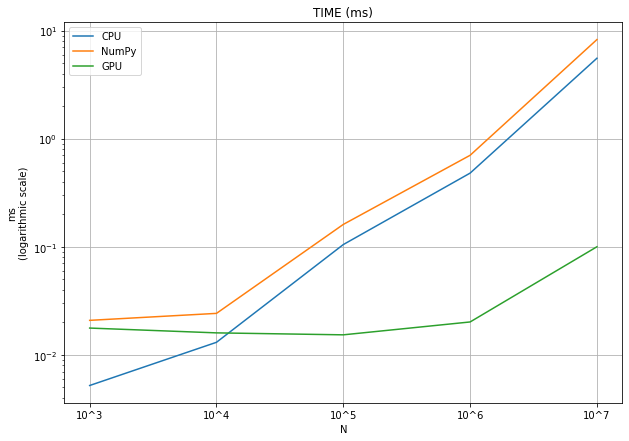

In [12]:
plt.figure(figsize=(10, 7))

ax = plt.axes()
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

plt.title('TIME (ms)')
plt.yscale('log')

plt.xlabel('N')
plt.ylabel('ms\n(logarithmic scale)')

plt.plot(df['CPU'].tolist(), label='CPU')
plt.plot(df['NumPy'].tolist(), label='NumPy')
plt.plot(df['GPU'].tolist(), label='GPU')

plt.grid()
plt.legend()

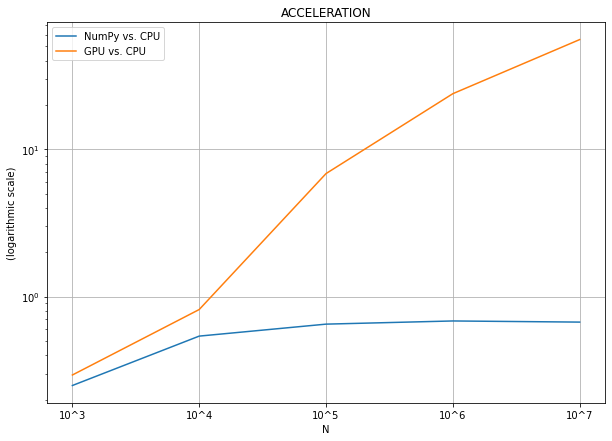

In [13]:
plt.figure(figsize=(10, 7))

ax = plt.axes()
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

plt.title('ACCELERATION')
plt.yscale('log')

plt.xlabel('N')
plt.ylabel('(logarithmic scale)')

plt.plot((df['CPU'] / df['NumPy']).tolist(), label='NumPy vs. CPU')
plt.plot((df['CPU'] / df['GPU']).tolist(), label='GPU vs. CPU')

plt.grid()
plt.legend()

Test #2

In [14]:
dims_to_test = [2**i for i in range(10, 26)]
dims_names = [f'2^{i}' for i in range(10, 26)]
repeats = 5

df = pd.DataFrame(columns=('CPU', 'NumPy', 'GPU'))

In [15]:
for n_str, n in zip(dims_names, dims_to_test):
    
    print(f'test n={n_str}')
    
    vec = np.random.randint(50, size=(n,)).astype(np.int32)
    
    s1 = cpu_vectorsum(vec)
    s2 = vec.sum()
    s3 = cuda_vectorsum(vec)['result']
    
    # print(s1, s2, s3)
    
    assert s1 == s2
    assert s2 == s3
    assert s3 == s1

    gpu_times = np.zeros(repeats, dtype=np.float)
    for i in range(repeats):
        gpu_times[i] = cuda_vectorsum(vec)['time']
    gpu_time = gpu_times.mean()  # in ms

    cpu_time = timeit(lambda: cpu_vectorsum(vec), number=repeats) / repeats  # in sec
    cpu_time *= 1000  # in ms
    
    numpy_time = timeit(lambda: vec.sum(), number=repeats) / repeats  # in sec
    numpy_time *= 1000  # in ms
    
    df.loc[n_str] = [cpu_time, numpy_time, gpu_time]
    

test n=2^10
test n=2^11
test n=2^12
test n=2^13
test n=2^14
test n=2^15
test n=2^16
test n=2^17
test n=2^18
test n=2^19
test n=2^20
test n=2^21
test n=2^22
test n=2^23
test n=2^24
test n=2^25


In [16]:
# df

In [17]:
print(df.to_markdown())

|      |         CPU |      NumPy |       GPU |
|:-----|------------:|-----------:|----------:|
| 2^10 |  0.00244821 |  0.0136666 | 0.0108032 |
| 2^11 |  0.00295104 |  0.048239  | 0.0109696 |
| 2^12 |  0.00479883 |  0.010756  | 0.0112128 |
| 2^13 |  0.00786739 |  0.0150646 | 0.008096  |
| 2^14 |  0.00985158 |  0.0177864 | 0.0075072 |
| 2^15 |  0.0184298  |  0.0299562 | 0.010432  |
| 2^16 |  0.0354864  |  0.05376   | 0.0133312 |
| 2^17 |  0.0633006  |  0.0954564 | 0.0143552 |
| 2^18 |  0.123436   |  0.194937  | 0.0140928 |
| 2^19 |  0.250982   |  0.379408  | 0.02064   |
| 2^20 |  0.490977   |  0.739468  | 0.0201664 |
| 2^21 |  1.00356    |  1.46698   | 0.0328256 |
| 2^22 |  2.30615    |  3.31979   | 0.0500032 |
| 2^23 |  4.58195    |  6.86304   | 0.0862912 |
| 2^24 |  9.35645    | 13.9229    | 0.158752  |
| 2^25 | 18.411      | 28.326     | 0.303661  |


In [18]:
xticks = range(len(df.index))
xticklabels = df.index.tolist()

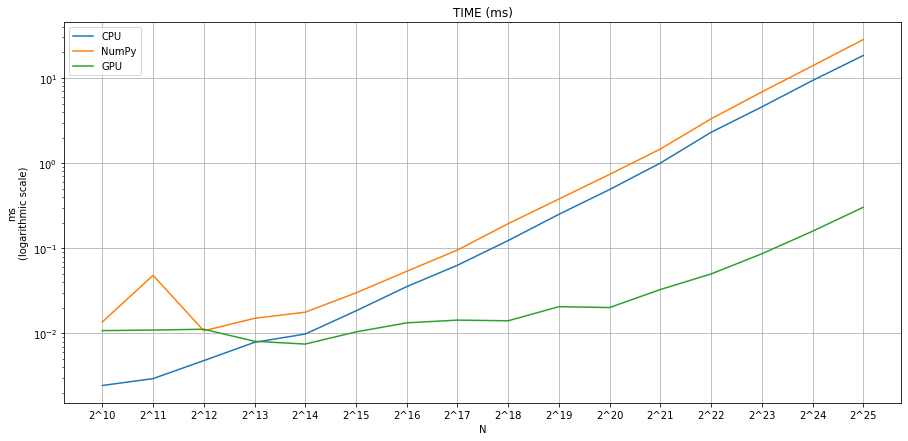

In [19]:
plt.figure(figsize=(15, 7))

ax = plt.axes()
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

plt.title('TIME (ms)')
plt.yscale('log')

plt.xlabel('N')
plt.ylabel('ms\n(logarithmic scale)')

plt.plot(df['CPU'].tolist(), label='CPU')
plt.plot(df['NumPy'].tolist(), label='NumPy')
plt.plot(df['GPU'].tolist(), label='GPU')

plt.grid()
plt.legend()

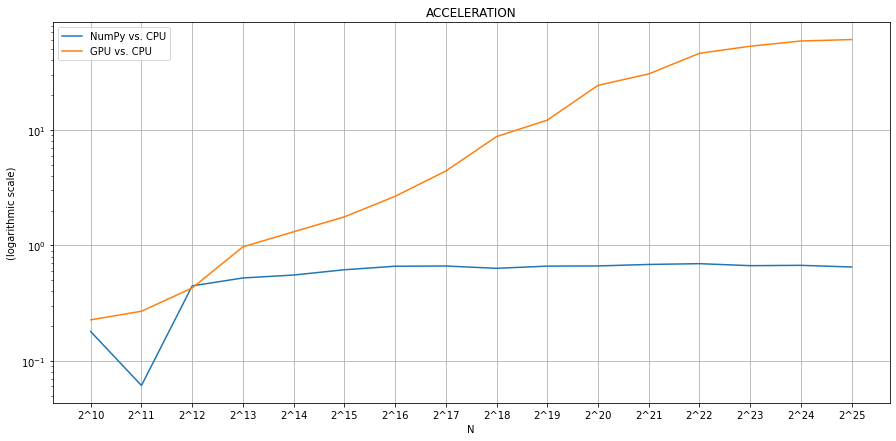

In [20]:
plt.figure(figsize=(15, 7))

ax = plt.axes()
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

plt.title('ACCELERATION')
plt.yscale('log')

plt.xlabel('N')
plt.ylabel('(logarithmic scale)')

plt.plot((df['CPU'] / df['NumPy']).tolist(), label='NumPy vs. CPU')
plt.plot((df['CPU'] / df['GPU']).tolist(), label='GPU vs. CPU')

plt.grid()
plt.legend()